In [4]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("labeled_data.csv")

In [6]:
# df1=df[df['class']==0]
# df2=df[df['class']==1]
# df3=df[df['class']==2]

In [7]:
# df4=df2.sample(df1.shape[0])
# df4.shape

In [8]:
# df5=df3.sample(df1.shape[0])
# df5.shape

In [9]:
# train_df=pd.concat([df1,df4,df5])
# train_df.shape

In [10]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
train_df['tweet'].value_counts()

tweet
!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...          1
RT @MurderHigashi: I cannot be worried 'bout no bitch.                                                                                                1
RT @MrPerfect_22: Most of these niggas go broke for these hoes !!                                                                                     1
RT @MrPOONsoaker: Foh RT @Thotcho: @MrPOONsoaker lmao 6&#8242;0 but I&#8217;m hella skinny so bitches don&#8217;t like me                             1
RT @MrNationWide: fake eyelashes are okay if they look natural, but some of you bitches look like you gonna take flight if you blink too fa&#8230;    1
                                                                                                                                                     ..
But she can shade the shit out a bitch RT @axolROSE: #YourWifeCantRead            

In [12]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [13]:
# text processing function

import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text)
    #text = re.sub('\w+\W', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove next line
    text = re.sub(r'[^ \w\.]', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    return text
# Create a new column called "Text" for collecting clean text
train_df['Text'] = train_df.tweet.apply(lambda x: clean_text(x))

In [14]:
X_data = train_df[['Text']].to_numpy().reshape(-1)
y_data = train_df[['class']].to_numpy().reshape(-1)

In [15]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,Text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cl...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat ...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she st...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true ...


In [16]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = train_df['class'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 24783
Number of categories: 3
Done!


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777)

In [18]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [19]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
train_dataset = CustomDataset(X_train, y_train, tokenizer, max_len=64)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [21]:
test_dataset = CustomDataset(X_test, y_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [23]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%')

Epoch 1/3, Loss: 0.5313, Accuracy: 80.51%
Epoch 2/3, Loss: 0.3829, Accuracy: 87.95%
Epoch 3/3, Loss: 0.6414, Accuracy: 79.10%


In [24]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       441
           1       0.86      0.97      0.91      5718
           2       0.74      0.58      0.65      1276

    accuracy                           0.84      7435
   macro avg       0.53      0.52      0.52      7435
weighted avg       0.79      0.84      0.81      7435



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
cm = confusion_matrix(true_labels, predictions)

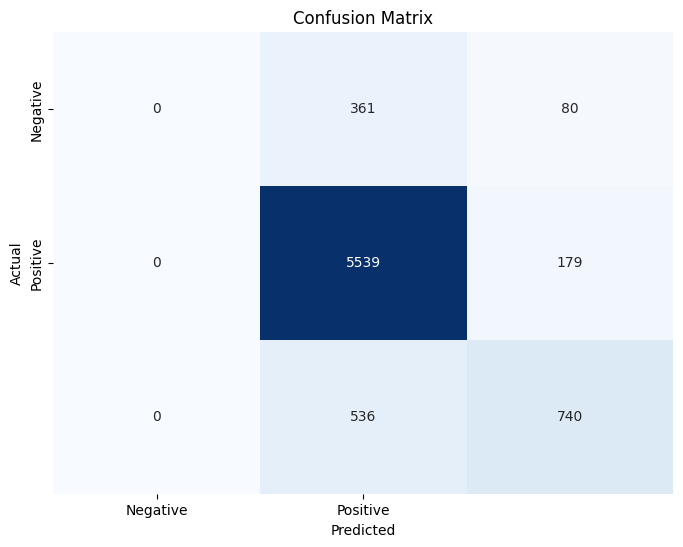

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(true_labels, predictions)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8445191661062542


In [29]:
import joblib

In [31]:
model_filename = 'trained_model.pkl'
joblib.dump(model, model_filename)
print("Model saved as:", model_filename)

Model saved as: trained_model.pkl
